In [10]:
import pandas as pd
try:
  import xml.etree.cElementTree as et
except ImportError:
  import xml.etree.ElementTree as et
import numpy as np   
import math
from sklearn.model_selection import KFold
import scipy
import os

K_DEPTH_VIEW = 30
K_DEPTH_SAT = 10
MAX_REL = 4
MED_REL = 2.5

In [11]:
'''
Parse THUIR1
'''
DATA_DIR = "THUIR1/search_sessions/"
SCORE_FILE="THUIR1/metrics.txt"
REL_FILE = "THUIR1/relevance.txt"

In [12]:
parsed_log = []
ss = [] # score list
rels = [] # relevance list

with open (SCORE_FILE, 'r+', encoding = 'utf-8') as f:
    ss = [i[:-1].split('\t') for i in f.readlines()]
    
with open (REL_FILE, 'r+', encoding = 'utf-8') as f:
    rels = [i[:-1].split('\t') for i in f.readlines()]

cnt_err = 0
for rec in ss:
    sat = -1
    session_id = rec[0]
    serp_id = session_id.split('_')[1]
    cl = [] # click list
    # Parse log
    #print(session_id)
    try:
        with open (DATA_DIR+session_id, 'r+', encoding = 'utf-8') as f:
            for i in f.readlines():
                l = i[:-1].split('\t')
                if l[2] == 'ACTION=SATISFY':
                    # Extract satisfaction score
                    sat = float(l[4][-1])
                if l[2] == 'ACTION=CLICK':
                    # Extract distinct click record
                    c = int(l[5][-1])
                    if c not in cl:
                        cl.append(c)             
    except:
        cnt_err += 1
        continue
    nc = len(cl)
    if nc:
        dc = max(cl) + 1
    else:
        dc = 0
    query_result = []
    for rel in rels:
        if rel[0] == serp_id:
            for rank in range(0,10):
                query_result.append({'doc_id':serp_id + str(rank), 'doc_rank': str(rank), 'doc_rel': str(rel[rank+1])})
    
    
    parsed_log.append({'id':session_id, 'result':query_result, 'sat': str(sat), 'nc': str(nc), 'dc': str(dc)})       


print("Success: %s, Failure: %s"%(len(parsed_log), cnt_err))
print(parsed_log[1000])

Success: 2391, Failure: 44
{'id': '29_52', 'result': [{'doc_id': '520', 'doc_rank': '0', 'doc_rel': '1.7'}, {'doc_id': '521', 'doc_rank': '1', 'doc_rel': '1.7'}, {'doc_id': '522', 'doc_rank': '2', 'doc_rel': '2.0'}, {'doc_id': '523', 'doc_rank': '3', 'doc_rel': '2.0'}, {'doc_id': '524', 'doc_rank': '4', 'doc_rel': '2.0'}, {'doc_id': '525', 'doc_rank': '5', 'doc_rel': '2.0'}, {'doc_id': '526', 'doc_rank': '6', 'doc_rel': '2.0'}, {'doc_id': '527', 'doc_rank': '7', 'doc_rel': '2.0'}, {'doc_id': '528', 'doc_rank': '8', 'doc_rel': '2.0'}, {'doc_id': '529', 'doc_rank': '9', 'doc_rel': '3.7'}], 'sat': '2.0', 'nc': '2', 'dc': '4'}


In [4]:
def decay_dcg (b, n):
    return 1.0/(1+ math.log(n,b))

def s_insq(x):
    res = 0
    for i in range(1, x+1):
        res += 1/i**2
    return math.pi**2 / 6 - res

def s_decay_dcg(b, x):
    res = 0
    for i in range(1, x+1):
        res += 1.0/(1+ math.log(x, b))
    return res

def gain(rel):
    return rel

def gain_err(rel):
    return (2**rel - 1)/2**MAX_REL

# The probability users view the document at rank n
# Supposed they always view the first document
def v_dcg(b, n):
    return (1+ math.log(1, b))/(1+ math.log(n, b))

def v_rbp(p, n):
    return p**(n-1)

def v_insq(t, n, last_prob):
    if n == 1:
        return 1
    else:
        return last_prob * ((n + 2*t - 2)/(n + 2*t -1))**2
    
def v_inst(t, n, cr, last_prob):
    if n == 1:
        return 1
    else:
        tn = t - cr
        return last_prob * ((n + t + tn - 2)/(n + t + tn - 1))**2
    
def v_e9(n, last_r, last_prob):
    if n == 1:
        return 1
    else:
        return (n-1) * (1- gain_err(last_r))/n * last_prob
        
def w_dcg(b, n):
    return decay_dcg(b, n) / s_decay_dcg(b, K_DEPTH_SAT)
        
def w_rbp(p, n):
    return (1-p) * (p**(n-1))

def w_err(rank, last_prob):
    return (1.0/rank) * last_prob

def w_p():
    return 1/K_DEPTH_SAT 

def w_insq(t, n):
    return (1/s_insq(2*t-1)) * (1/(n + 2*t - 1)**2)

def w_inst(t, n, cr):
    return (1/s_insq(2*t-1)) * (1/(n + 2*t - cr -1)**2)

def w_e9(n, last_r, last_prob, sum_v):
    return v_e9(n, last_r, last_prob) / sum_v
    


In [5]:
DCG_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
RBP_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
INSQ_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
INST_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
E9_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}

METRIC = {'DCG':'dcg', 'RBP':'rbp', 'ERR':'err', 'P':'p', 'INSQ':'insq', 'INST':'inst', 'E9':'e9'}

'''
RQ1 - How to issue a new framework incorporating the anchoring effect into IR metrics
'''

def default_run(pm, result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    res = 0
    last_prob = 1.0 # For ERR
    cr = 0 # For INST
    '''
    last_r = 0,  last_prob_e9 = 1, sum_v = 0 # For E9
    if metric == 'E9':
        for doc in result_list:
            if int(doc['doc_rank'])< K_DEPTH_SAT:
                cur_rel = float(doc['doc_rel'])
                cur_rank = int(doc['doc_rank'])+1
                v = v_e9(n, last_r, last_prob_e9)
                sum_v += v
                last_r = cur_rel
                last_prob_e9 = v
        last_r = 0
        last_prob_e9 = 1
    '''        
    for doc in result_list:
        if int(doc['doc_rank'])< K_DEPTH_SAT:
            cur_rel = float(doc['doc_rel'])
            cur_rank = int(doc['doc_rank'])+1
            if metric == 'DCG':
                cur_gain = gain(cur_rel)*w_dcg(pm, cur_rank)
            elif metric == 'RBP':
                cur_gain = gain(cur_rel)*w_rbp(pm, cur_rank)
            elif metric == 'ERR':
                cur_gain = gain_err(cur_rel)*w_err(cur_rank, last_prob)
                last_prob *= (1- gain_err(cur_rel))
            elif metric == 'P':
                cur_gain = gain(cur_rel)*w_p()
            elif metric == 'INSQ':
                cur_gain = gain(cur_rel) * w_insq(pm, cur_rank)
            elif metric == 'INST':
                cur_gain = gain(cur_rel) * w_inst(pm, cur_rank, cr)
                cr += cur_rel/MAX_REL
            '''
            elif metric == 'E9':
                cur_gain = gain_err(cur_rel) * w_e9(cur_rank, last_r, last_prob_e9, sum_v)
                last_prob_e9 = v_e9(cur_rank, last_r, last_prob_e9)
                last_r = cur_rel
            '''
            res += cur_gain
    return res

def AEM_run(pm, l, k,result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    res = 0.0
    last_rel = -1.0
    # For ERR
    last_prob = 1.0
    # For INST
    cr = 0
    for doc in result_list:
        cur_rank = int(doc['doc_rank']) + 1
        if cur_rank <= K_DEPTH_SAT:
            # First doc
            if cur_rank == 1:
                cur_rel = float(doc['doc_rel'])
            else:
                x = (last_rel - MED_REL)/(MAX_REL-MED_REL)
                a = l / (k + math.exp(-(1/k)*(x)))
                if a > l:
                    a = l
                cur_rel = a*last_rel + (1-a)*float(doc['doc_rel'])
                
            # We assume that users assess documents objectively, 
            # but their gain from the current document is affected by the quality of the last document
            if metric == 'DCG':
                cur_gain = gain(cur_rel)*w_dcg(pm, cur_rank)
            elif metric == 'RBP':
                cur_gain = gain(cur_rel)*w_rbp(pm, cur_rank)
            elif metric == 'ERR':
                cur_gain = gain_err(cur_rel)*w_err(cur_rank, last_prob)
                last_prob *= (1-gain_err(cur_rel))
            elif metric == 'P':
                cur_gain =  gain(cur_rel)*w_p()
            elif metric == 'INSQ':
                cur_gain = gain(cur_rel) * w_insq(pm, cur_rank)
            elif metric == 'INST':
                cur_gain = gain(cur_rel)*w_inst(pm, cur_rank, cr)
                cr += cur_rel/MAX_REL
        else:
            break
        res += cur_gain
        # Real Quality
        last_rel = float(doc['doc_rel'])
        #last_rel = cur_rel
    #print(res)
    return res
        
def compute_TSE(train_set, metric, pm):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    tse = 0
    last_prob = 1 # For INSQ & INST
    cr = 0 # For INST
    for q in train_set:
        dc = int(q['dc'])
        nc = int(q['nc'])
        for rank in range(1, K_DEPTH_VIEW+1):
            if metric == 'DCG':
                p_dr_hat = v_dcg(pm, rank)
            elif metric == 'RBP':
                p_dr_hat = v_rbp(pm, rank)
            elif metric == 'INSQ':
                p_dr_hat = v_insq(pm, rank, last_prob)
                last_prob *= p_dr_hat
            # We assume that the relevance of documents 
            # at depth larger than assessment depth is 0
            elif metric == 'INST':
                if rank <= K_DEPTH_SAT:
                    cur_rel = float(q['result'][rank-1]['doc_rel'])
                else:
                    cur_rel = 0
                p_dr_hat = v_inst(pm, rank, cr, last_prob)
                last_prob *= p_dr_hat
                cr += cur_rel/MAX_REL
                
            if rank <= dc:
                p_dr = 1
            else:
                n = rank - dc
                #k = 5.1 + dc* 0.29 - nc*0.14 # Wickasono(2021) Model2
                k = 3.48 - dc* 0.46 + nc * 0.2  # Wickasono(2020) for THUIR1
                if(k < 0):
                    p_dr = 0
                else:
                    p_dr = math.exp((-1.0*n)/k)
            tse += (p_dr_hat - p_dr)**2
            
    return tse
        
'''
Grid Search for DCG
'''
def train_dcg_baseline(train_set, mode):
    if mode not in DCG_MODE:
        raise Exception('No such mode: %s'%(mode))
    
    dcg_b={}   
    for b in np.arange(1.1, 5.01, 0.1):
        b = round(b, 2)
        if mode == 'BEHAVIOUR':
            dcg_b[b] = compute_TSE(train_set, 'DCG', b)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(b, q['result'],  'DCG') for q in train_set]
            dcg_b[b] = scipy.stats.spearmanr(X, Y).correlation
    
    if mode == 'BEHAVIOUR':
        b_st = min(dcg_b, key = dcg_b.get)
    elif mode == 'SATISFACTION':
        b_st = max(dcg_b, key = dcg_b.get)
        
    return b_st


'''
Grid Search for RBP
'''
def train_rbp_baseline(train_set, mode):
    if mode not in RBP_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    rbp_p = {}
    for p in np.arange(0, 1.01, 0.05):
        p = round(p, 2)
        if mode == 'BEHAVIOUR':
            rbp_p[p] = compute_TSE(train_set, 'RBP', p)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(p, q['result'], 'RBP') for q in train_set]
            rbp_p[p] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        p_st = min(rbp_p, key = rbp_p.get)
    elif mode == 'SATISFACTION':
        p_st = max(rbp_p, key = rbp_p.get)
        
    return p_st
        
'''
Grid Search for INSQ
'''
def train_insq_baseline(train_set, mode):
    if mode not in INSQ_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    insq_t = {}
    for t in range(1, 26):
        if mode == 'BEHAVIOUR':
            insq_t[t] = compute_TSE(train_set, 'INSQ', t)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(t, q['result'], 'INSQ') for q in train_set]
            insq_t[t] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        t_st = min(insq_t, key = insq_t.get)
    elif mode == 'SATISFACTION':
        t_st = max(insq_t, key = insq_t.get)
        
    return t_st

        
'''
Grid Search for INST
'''
def train_inst_baseline(train_set, mode):
    if mode not in INST_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    inst_t = {}
    for t in range(1, 26):
        if mode == 'BEHAVIOUR':
            inst_t[t] = compute_TSE(train_set, 'INST', t)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(t, q['result'], 'INST') for q in train_set]
            inst_t[t] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        t_st = min(inst_t, key = inst_t.get)
    elif mode == 'SATISFACTION':
        t_st = max(inst_t, key = inst_t.get)
        
    return t_st

'''
Grid Search for Callibrating lambda and kappa for AEMs
'''

def train_AEM(pm, train_set, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    map_aem = {}
    Y = [float(q['sat']) for q in train_set]
    for l in np.arange(0, 1.01, 0.1):
        l = round(l, 3)
        for k in np.arange(0, 0.501, 0.05):
            k = round(k, 4)
            if metric == 'DCG':
                X = [AEM_run(pm, l, k, q['result'], 'DCG') for q in train_set]
            elif metric == 'RBP':
                X = [AEM_run(pm, l, k, q['result'], 'RBP') for q in train_set]
            elif metric == 'ERR':
                X =  [AEM_run(pm, l, k, q['result'], 'ERR') for q in train_set]
            elif metric == 'P':
                X =  [AEM_run(pm, l, k, q['result'], 'P') for q in train_set]
            elif metric == 'INSQ':
                X =  [AEM_run(pm, l, k, q['result'], 'INSQ') for q in train_set]
            elif metric == 'INST':
                X =  [AEM_run(pm, l, k, q['result'], 'INST') for q in train_set]
            if not(l in map_aem):
                map_aem[l] = {}
            map_aem[l][k] = scipy.stats.spearmanr(X, Y).correlation
    # Find best parameter   
    r = -1
    l_st = -1
    k_st = -1
    for l in map_aem:
        for k in map_aem[l]:
            if map_aem[l][k] > r:
                r = map_aem[l][k]
                l_st = l
                k_st = k
    return (l_st, k_st)


In [6]:
rl_dcg_b = []
rl_dcg_s = []
rl_dcg_AEM = []

rl_rbp_b = []
rl_rbp_s = []
rl_rbp_AEM = []

rl_err = []
rl_err_AEM = []

rl_p = []
rl_p_AEM = []

rl_insq_b = []
rl_insq_s = []
rl_insq_AEM = []

rl_inst_b = []
rl_inst_s = []
rl_inst_AEM = []

l1s = []
k1s = []
bbs = []
bss = []

l2s = []
k2s = []
pbs = []
pss = []

l3s = []
k3s = []

l4s = []
k4s = []

l5s = []
k5s = []
t1bs = []
t1ss = []

l6s = []
k6s = []
t2bs = []
t2ss = []

tt = 0

for i in range(0, 10):
    kf = KFold(n_splits=5,shuffle=True)
    for train_index , test_index in kf.split(parsed_log): 
        tt+=1
        print('training: %s'%(tt))
        train_set = [parsed_log[i] for i in train_index]
        test_set = [parsed_log[i] for i in test_index]

        b_b = train_dcg_baseline(train_set, 'BEHAVIOUR')
        b_s = train_dcg_baseline(train_set, 'SATISFACTION')
        l_1, k_1 = train_AEM(b_b, train_set, 'DCG')
        l1s.append(l_1)
        k1s.append(k_1)
        bbs.append(b_b)
        bss.append(b_s)
        
        p_b = train_rbp_baseline(train_set, 'BEHAVIOUR')
        p_s = train_rbp_baseline(train_set, 'SATISFACTION')
        l_2, k_2 = train_AEM(p_b, train_set, 'RBP')
        l2s.append(l_2)
        k2s.append(k_2)
        pbs.append(p_b)
        pss.append(p_s)
        
        l_3, k_3 = train_AEM(-1, train_set, 'ERR')
        l3s.append(l_3)
        k3s.append(k_3)
        
        l_4, k_4 = train_AEM(-1, train_set, 'P')
        l4s.append(l_4)
        k4s.append(k_4)
        
        t1_b = train_insq_baseline(train_set, 'BEHAVIOUR')
        t1_s = train_insq_baseline(train_set, 'SATISFACTION')
        l_5, k_5 = train_AEM(t1_b, train_set, 'INSQ')
        l5s.append(l_5)
        k5s.append(k_5)
        t1bs.append(t1_b)
        t1ss.append(t1_s)
        
        t2_b = train_inst_baseline(train_set, 'BEHAVIOUR')
        t2_s = train_inst_baseline(train_set, 'SATISFACTION')
        l_6, k_6 = train_AEM(t2_b, train_set, 'INST')
        l6s.append(l_6)
        k6s.append(k_6)
        t2bs.append(t2_b)
        t2ss.append(t2_s)
        
        X_dcg_b = [default_run(b_b, q['result'], 'DCG') for q in test_set]
        X_dcg_s = [default_run(b_s, q['result'], 'DCG') for q in test_set]
        X_dcg_AEM = [AEM_run(b_b, l_1 , k_1, q['result'], 'DCG') for q in test_set]
        
        X_rbp_b = [default_run(p_b, q['result'], 'RBP') for q in test_set]
        X_rbp_s = [default_run(p_s, q['result'], 'RBP') for q in test_set]
        X_rbp_AEM = [AEM_run(p_b, l_2 , k_2, q['result'], 'RBP') for q in test_set]
        
        X_err = [default_run(-1, q['result'], 'ERR')  for q in test_set]
        X_err_AEM = [AEM_run(-1, l_3 , k_3, q['result'], 'ERR') for q in test_set]
        
        X_p = [default_run(-1, q['result'], 'P')  for q in test_set]
        X_p_AEM = [AEM_run(-1, l_4 , k_4, q['result'], 'P') for q in test_set]
        
        X_insq_b = [default_run(t1_b, q['result'], 'INSQ') for q in test_set]
        X_insq_s = [default_run(t1_s, q['result'], 'INSQ') for q in test_set]
        X_insq_AEM = [AEM_run(t1_b, l_5 , k_5, q['result'], 'INSQ') for q in test_set]
        
        X_inst_b = [default_run(t2_b, q['result'], 'INST') for q in test_set]
        X_inst_s = [default_run(t2_s, q['result'], 'INST') for q in test_set]
        X_inst_AEM = [AEM_run(t2_b, l_6 , k_6, q['result'], 'INST') for q in test_set]
        
        Y = [float(q['sat']) for q in test_set]
        
        rl_dcg_b.append(scipy.stats.spearmanr(X_dcg_b, Y).correlation)
        rl_dcg_s.append(scipy.stats.spearmanr(X_dcg_s, Y).correlation)
        rl_dcg_AEM.append(scipy.stats.spearmanr(X_dcg_AEM, Y).correlation)
        print("DCG b_b=%3f b_s = %3f b-rel=%4f s-rel=%4f"%(b_b, b_s, scipy.stats.spearmanr(X_dcg_b, Y).correlation, scipy.stats.spearmanr(X_dcg_s, Y).correlation))
        print("AEM-DCG lambda=%3f, kappa=%3f rel=%4f"%(l_1, k_1, scipy.stats.spearmanr(X_dcg_AEM, Y).correlation))
    
        rl_rbp_b.append(scipy.stats.spearmanr(X_rbp_b, Y).correlation)
        rl_rbp_s.append(scipy.stats.spearmanr(X_rbp_s, Y).correlation)
        rl_rbp_AEM.append(scipy.stats.spearmanr(X_rbp_AEM, Y).correlation)
        print("RBP p_b=%3f, p_s=%3f b-rel=%4f s-rel=%4f"%(p_b, p_s, scipy.stats.spearmanr(X_rbp_b, Y).correlation, scipy.stats.spearmanr(X_rbp_s, Y).correlation))
        print("AEM-RBP lambda=%3f, kappa=%3f rel=%4f"%(l_2, k_2, scipy.stats.spearmanr(X_rbp_AEM, Y).correlation))
        
        rl_err.append(scipy.stats.spearmanr(X_err, Y).correlation)
        rl_err_AEM.append(scipy.stats.spearmanr(X_err_AEM, Y).correlation)
        print("ERR rel=%4f"%(scipy.stats.spearmanr(X_err, Y).correlation))
        print("AEM-ERR lambda=%3f, kappa=%3f rel=%4f"%(l_3, k_3, scipy.stats.spearmanr(X_err_AEM, Y).correlation))
        
        rl_p.append(scipy.stats.spearmanr(X_p, Y).correlation)
        rl_p_AEM.append(scipy.stats.spearmanr(X_p_AEM, Y).correlation)
        print("Prec rel=%4f"%(scipy.stats.spearmanr(X_p, Y).correlation))
        print("AEM-Prec lambda=%3f, kappa=%3f rel=%4f"%(l_4, k_4, scipy.stats.spearmanr(X_p_AEM, Y).correlation))
        
        rl_insq_b.append(scipy.stats.spearmanr(X_insq_b, Y).correlation)
        rl_insq_s.append(scipy.stats.spearmanr(X_insq_s, Y).correlation)
        rl_insq_AEM.append(scipy.stats.spearmanr(X_insq_AEM, Y).correlation)
        print("INSQ t_b=%3f t_s = %3f b-rel=%4f s-rel=%4f"%(t1_b, t1_s, scipy.stats.spearmanr(X_insq_b, Y).correlation, scipy.stats.spearmanr(X_insq_s, Y).correlation))
        print("AEM-INSQ lambda=%3f, kappa=%3f rel=%4f"%(l_5, k_5, scipy.stats.spearmanr(X_insq_AEM, Y).correlation))
        
        rl_inst_b.append(scipy.stats.spearmanr(X_inst_b, Y).correlation)
        rl_inst_s.append(scipy.stats.spearmanr(X_inst_s, Y).correlation)
        rl_inst_AEM.append(scipy.stats.spearmanr(X_inst_AEM, Y).correlation)
        print("INST t_b=%3f t_s = %3f b-rel=%4f s-rel=%4f"%(t2_b, t2_s, scipy.stats.spearmanr(X_inst_b, Y).correlation, scipy.stats.spearmanr(X_inst_s, Y).correlation))
        print("AEM-INST lambda=%3f, kappa=%3f rel=%4f"%(l_6, k_6, scipy.stats.spearmanr(X_inst_AEM, Y).correlation))
    

training: 1


/Users/kohira/anaconda2/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kohira/anaconda2/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/Users/kohira/anaconda2/envs/python3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kohira/anaconda2/envs/python3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


DCG b_b=1.600000 b_s = 1.800000 b-rel=0.364242 s-rel=0.355518
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.380760
RBP p_b=0.850000, p_s=0.750000 b-rel=0.328387 s-rel=0.366541
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.368135
ERR rel=0.383832
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.381579
Prec rel=0.220284
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.300247
INSQ t_b=4.000000 t_s = 3.000000 b-rel=0.336054 s-rel=0.353665
AEM-INSQ lambda=1.000000, kappa=0.300000 rel=0.374198
INST t_b=5.000000 t_s = 1.000000 b-rel=0.301715 s-rel=0.371184
AEM-INST lambda=1.000000, kappa=0.350000 rel=0.356137
training: 2
DCG b_b=1.600000 b_s = 1.400000 b-rel=0.268528 s-rel=0.257761
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.285503
RBP p_b=0.850000, p_s=0.750000 b-rel=0.282021 s-rel=0.272522
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.297956
ERR rel=0.215809
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.224909
Prec rel=0.257434
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.301218
INSQ t_b=4.0

DCG b_b=1.600000 b_s = 1.500000 b-rel=0.252999 s-rel=0.251927
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.286409
RBP p_b=0.850000, p_s=0.750000 b-rel=0.248814 s-rel=0.257786
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.292004
ERR rel=0.245813
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.260380
Prec rel=0.191867
AEM-Prec lambda=1.000000, kappa=0.400000 rel=0.270152
INSQ t_b=2.000000 t_s = 2.000000 b-rel=0.252960 s-rel=0.252960
AEM-INSQ lambda=1.000000, kappa=0.050000 rel=0.288345
INST t_b=3.000000 t_s = 1.000000 b-rel=0.244041 s-rel=0.252343
AEM-INST lambda=1.000000, kappa=0.300000 rel=0.290703
training: 16
DCG b_b=1.600000 b_s = 1.400000 b-rel=0.319442 s-rel=0.313594
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.327754
RBP p_b=0.850000, p_s=0.750000 b-rel=0.319671 s-rel=0.328081
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.337302
ERR rel=0.264955
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.266040
Prec rel=0.273557
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.316330
INSQ t_b=4.

DCG b_b=1.600000 b_s = 1.500000 b-rel=0.343531 s-rel=0.343599
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.354311
RBP p_b=0.850000, p_s=0.750000 b-rel=0.338755 s-rel=0.347711
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.351602
ERR rel=0.321899
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.322548
Prec rel=0.289966
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.332823
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.341608 s-rel=0.347220
AEM-INSQ lambda=1.000000, kappa=0.300000 rel=0.352624
INST t_b=5.000000 t_s = 1.000000 b-rel=0.332187 s-rel=0.347755
AEM-INST lambda=1.000000, kappa=0.350000 rel=0.348613
training: 30
DCG b_b=1.600000 b_s = 1.500000 b-rel=0.334559 s-rel=0.335740
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.364490
RBP p_b=0.850000, p_s=0.750000 b-rel=0.317066 s-rel=0.329318
AEM-RBP lambda=1.000000, kappa=0.350000 rel=0.358821
ERR rel=0.304728
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.310185
Prec rel=0.257139
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.338006
INSQ t_b=4.

DCG b_b=1.600000 b_s = 1.600000 b-rel=0.372915 s-rel=0.372915
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.406144
RBP p_b=0.850000, p_s=0.750000 b-rel=0.348511 s-rel=0.368689
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.404539
ERR rel=0.355017
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.355612
Prec rel=0.271589
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.359473
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.355858 s-rel=0.368165
AEM-INSQ lambda=1.000000, kappa=0.400000 rel=0.402684
INST t_b=5.000000 t_s = 1.000000 b-rel=0.334737 s-rel=0.364919
AEM-INST lambda=1.000000, kappa=0.350000 rel=0.397486
training: 44
DCG b_b=1.600000 b_s = 1.500000 b-rel=0.341562 s-rel=0.341833
AEM-DCG lambda=1.000000, kappa=0.050000 rel=0.365237
RBP p_b=0.850000, p_s=0.750000 b-rel=0.338560 s-rel=0.353243
AEM-RBP lambda=1.000000, kappa=0.250000 rel=0.378711
ERR rel=0.323462
AEM-ERR lambda=1.000000, kappa=0.050000 rel=0.338353
Prec rel=0.275288
AEM-Prec lambda=1.000000, kappa=0.400000 rel=0.341432
INSQ t_b=4.

In [8]:
rl_dcg_b = pd.Series(rl_dcg_b)
rl_dcg_s = pd.Series(rl_dcg_s)
rl_dcg_AEM = pd.Series(rl_dcg_AEM)

rl_rbp_b = pd.Series(rl_rbp_b)
rl_rbp_s = pd.Series(rl_rbp_s)
rl_rbp_AEM = pd.Series(rl_rbp_AEM)

rl_err = pd.Series(rl_err)
rl_err_AEM = pd.Series(rl_err_AEM)

rl_p = pd.Series(rl_p)
rl_p_AEM = pd.Series(rl_p_AEM)

rl_insq_b = pd.Series(rl_insq_b)
rl_insq_s = pd.Series(rl_insq_s)
rl_insq_AEM = pd.Series(rl_insq_AEM)

rl_inst_b = pd.Series(rl_inst_b)
rl_inst_s = pd.Series(rl_inst_s)
rl_inst_AEM = pd.Series(rl_inst_AEM)

l1s = pd.Series(l1s)
k1s = pd.Series(k1s)
bbs = pd.Series(bbs)
bss =  pd.Series(bss)

l2s = pd.Series(l2s)
k2s = pd.Series(k2s)
pbs =  pd.Series(pbs)
pss =  pd.Series(pss)

l3s = pd.Series(l3s)
k3s = pd.Series(k3s)

l4s = pd.Series(l4s)
k4s = pd.Series(k4s)

l5s = pd.Series(l5s)
k5s = pd.Series(k5s)
t1bs = pd.Series(t1bs)
t1ss =  pd.Series(t1ss)

l6s = pd.Series(l6s)
k6s = pd.Series(k6s)
t2bs = pd.Series(t2bs)
t2ss =  pd.Series(t2ss)

In [17]:
'''
RQ2 - The peformance of AEMs compared with SOTA metrics
'''

print('############')
print('b_b Mean: %.3f    Std:%.3f    DCG_UB Mean: %.3f    Std:%.3f      '%(bbs.mean(), bbs.std(), rl_dcg_b.mean(), rl_dcg_b.std())) 
print('############')
print('b_s Mean: %.3f    Std:%.3f    DCG_US Mean: %.3f     Std:%.3f       '%(bss.mean(), bss.std(), rl_dcg_s.mean(), rl_dcg_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_DCG Mean: %.3f     Std:%.4f'%(l1s.mean(), l1s.std(), k1s.mean(), k1s.std(), rl_dcg_AEM.mean(), rl_dcg_AEM.std()))
print('############')
stat, p = scipy.stats.ttest_rel(rl_dcg_b, rl_dcg_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_rel(rl_dcg_s, rl_dcg_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('p_b Mean: %.3f    Std:%.3f    RBP_UB Mean: %.3f     Std:%.3f    '%(pbs.mean(), pbs.std(),rl_rbp_b.mean(), rl_rbp_b.std())) 
print('############')
print('p_s Mean: %.3f    Std:%.3f    RBP_US Mean: %.3f     Std:%.3f   '%(pss.mean(), pss.std(), rl_rbp_s.mean(), rl_rbp_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_RBP Mean: %.3f     Std:%.4f'%(l2s.mean(), l2s.std(), k2s.mean(), k2s.std(), rl_rbp_AEM.mean(), rl_rbp_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_rel(rl_rbp_b, rl_rbp_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_rel(rl_rbp_s, rl_rbp_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('ERR Mean: %.3f     Std:%.3f'%(rl_err.mean(), rl_err.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_ERR Mean: %.3f     Std:%.4f'%(l3s.mean(), l3s.std(), k3s.mean(), k3s.std(), rl_err_AEM.mean(), rl_err_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_rel(rl_err, rl_err_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('Prec Mean: %.3f     Std:%.3f'%(rl_p.mean(), rl_p.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_Prec Mean: %.3f     Std:%.4f'%(l4s.mean(), l4s.std(), k4s.mean(), k4s.std(), rl_p_AEM.mean(), rl_p_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_rel(rl_p, rl_p_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('t_b Mean: %.3f    Std:%.3f    INSQ_UB Mean: %.3f     Std:%.3f    '%(t1bs.mean(), t1bs.std(),rl_insq_b.mean(), rl_insq_b.std())) 
print('############')
print('t_s Mean: %.3f    Std:%.3f    INSQ_US Mean: %.3f     Std:%.3f   '%(t1ss.mean(), t1ss.std(), rl_insq_s.mean(), rl_insq_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_INSQ Mean: %.3f     Std:%.4f'%(l5s.mean(), l5s.std(), k5s.mean(), k5s.std(), rl_insq_AEM.mean(), rl_insq_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_rel(rl_insq_b, rl_insq_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_rel(rl_insq_s, rl_insq_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('t_b Mean: %.3f    Std:%.3f    INST_UB Mean: %.3f     Std:%.3f    '%(t2bs.mean(), t2bs.std(),rl_inst_b.mean(), rl_inst_b.std())) 
print('############')
print('t_s Mean: %.3f    Std:%.3f    INST_US Mean: %.3f     Std:%.3f   '%(t2ss.mean(), t2ss.std(), rl_inst_s.mean(), rl_inst_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_INST Mean: %.3f     Std:%.4f'%(l6s.mean(), l6s.std(), k6s.mean(), k6s.std(), rl_inst_AEM.mean(), rl_inst_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_rel(rl_inst_b, rl_inst_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_rel(rl_inst_s, rl_inst_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))



############
b_b Mean: 1.600    Std:0.000    DCG_UB Mean: 0.339    Std:0.038      
############
b_s Mean: 1.524    Std:0.089    DCG_US Mean: 0.337     Std:0.040       
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.050    Std:0.000    AEM_DCG Mean: 0.360     Std:0.0384
############
stat=-14.779, p=0.0000
stat=-17.199, p=0.0000
############
p_b Mean: 0.850    Std:0.000    RBP_UB Mean: 0.326     Std:0.037    
############
p_s Mean: 0.750    Std:0.000    RBP_US Mean: 0.340     Std:0.039   
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.261    Std:0.031    AEM_RBP Mean: 0.360     Std:0.0380
############
stat=-16.559, p=0.0000
stat=-11.465, p=0.0000
############
ERR Mean: 0.315     Std:0.042
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.050    Std:0.000    AEM_ERR Mean: 0.319     Std:0.0413
############
stat=-5.860, p=0.0000
############
Prec Mean: 0.264     Std:0.034
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.359    Std:0.039

In [14]:
'''
About Kappa
'''
import matplotlib.pyplot as plt

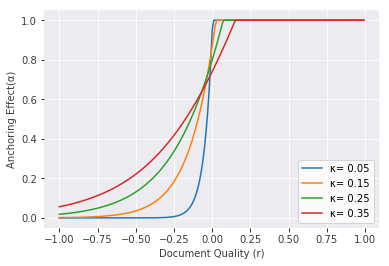

In [16]:
k_1 = 0.05
k_2 = 0.15
k_3 = 0.25
k_4 = 0.35

x = [i for i in np.arange(-1, 1, 0.01)]
y1 = []
y2 = []
y3 = []
y4 = []
for i in x:
    y1.append(min(1/(k_1 + math.exp(-(1/k_1)*(i))), 1))
    y2.append(min(1/(k_2 + math.exp(-(1/k_2)*(i))), 1))
    y3.append(min(1/(k_3 + math.exp(-(1/k_3)*(i))), 1))
    y4.append(min(1/(k_4 + math.exp(-(1/k_4)*(i))), 1))
    
#plt.figure(figsize=(14, 9))
plt.plot(x, y1, label = "κ= %.2f"%(k_1))
plt.plot(x, y2, label = "κ= %.2f"%(k_2))
plt.plot(x, y3, label = "κ= %.2f"%(k_3))
plt.plot(x, y4, label = "κ= %.2f"%(k_4))

ax = plt.gca()

ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框

plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")

plt.xlabel('Document Quality (r)', color = "#3c3c3c")
plt.ylabel('Anchoring Effect(α)', color = "#3c3c3c")

plt.legend(loc='lower right')
plt.savefig('kappa-compare.png', dpi=1100, bbox_inches='tight')

plt.show()

In [ ]:
'''
R with different kappa
'''
rbp_X = []
rbp_Y = []
dcg_X = []
dcg_Y = []

def search_AEM(pm, train_set, metric):
    aem = {}
    Y = [float(q['sat']) for q in train_set]
    for l in np.arange(1, 1.01, 1):
        l = round(l, 3)
        for k in np.arange(0.01, 0.101, 0.01):
            k = round(k, 4)
            if metric == 'RBP':
                X = [AEM_run(pm, l, k, q['result'], 'RBP') for q in train_set]
            elif metric == 'DCG':
                X = [AEM_run(pm, l, k, q['result'], 'DCG') for q in train_set]
            if l not in aem:
                aem[l] = {}
            aem[l][k] = scipy.stats.spearmanr(X, Y).correlation       
            
    for l in aem:
        for k in aem[l]:
            if metric == 'RBP':
                rbp_X.append(k)
                rbp_Y.append(aem[l][k])
            elif metric == 'DCG':
                dcg_X.append(k)
                dcg_Y.append(aem[l][k])                
    return
                             
search_AEM(1.9, parsed_log, 'DCG')            
search_AEM(0.55, parsed_log, 'RBP') 

In [ ]:
print(dcg_X)
print(dcg_Y)
print(rbp_X)
print(rbp_Y)

In [ ]:
#plt.figure(figsize=(14, 9))
plt.plot(dcg_X, dcg_Y, label = "DCG - b = 1.9")
plt.plot(rbp_X, rbp_Y, label = "RBP - p = 0.55")
ax = plt.gca()
ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框
plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")
plt.xlabel('κ', color = "#3c3c3c")
plt.ylabel('Spearman R', color = "#3c3c3c")
plt.ylim(0.28, 0.38)
plt.legend(loc='lower right')
plt.savefig('senstivity-compare.png', dpi=1100, bbox_inches='tight')
plt.show()

In [ ]:
doc_r = []
rbp_v1 = []
rbp_v2 = []
dcg_v1 = []
dcg_v2 = []
for i in range (1, K_DEPTH_SAT+1):
    doc_r.append(i)
    rbp_v1.append(decay_rbp(0.85 ,i))
    rbp_v2.append(decay_rbp(0.75 ,i))
    dcg_v1.append(decay_dcg(1.9 ,i))
    dcg_v2.append(decay_dcg(1.52 ,i))
plt.plot(doc_r, rbp_v1, label = "RBP - p = 0.85")
plt.plot(doc_r, rbp_v2, label = "RBP - p = 0.75")
plt.plot(doc_r, dcg_v1, label = "DCG - b = 1.9")
plt.plot(doc_r, dcg_v2, label = "DCG - b = 1.52")
ax = plt.gca()
ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框
plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")
plt.xlabel('Document Rank', color = "#3c3c3c")
plt.ylabel('Probability of User Accessing', color = "#3c3c3c")
plt.legend()
plt.savefig('rbp-compare.png', dpi=1100, bbox_inches='tight')
plt.show()